In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.dpi"] = 150

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.quantum_info import state_fidelity
import qiskit.ignis.mitigation.measurement as mc

from qiskit import IBMQ, transpile,Aer,execute
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from FPG import * # The functions from FP Grover Implementation notebook

# A Noisy Simulator Mimic a Real Backend

In [2]:
# Load IBMQ Account and choose a real backend
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmq_belem'
backend = provider.get_backend(name)

 # Record some information
basis_gates = backend.configuration().basis_gates
coupling_map = backend.configuration().coupling_map

# Create a noisy simulator using this backend
fake_backend = AerSimulator.from_backend(backend)

# A Naive Noisy Simulator

In [3]:
# Parameters
p_1q = 0.01 # 1-qubit depolarizing error rate
p_2q = 0.05 # 2-qubit depolarizing error rate

# Create an empty noise model
noise_model = NoiseModel(basis_gates) # Use the same basis_gates as the selected backend to ensure the circuit depth is the same

# Add depolarizing errors
error_1q = depolarizing_error(p_1q, 1)
error_2q = depolarizing_error(p_2q, 2)
noise_model.add_all_qubit_quantum_error(error_1q, ['id', 'rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

# Add the noise model to a simulator
sim_noise = AerSimulator(noise_model=noise_model)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'x', 'cx', 'rz', 'sx']
  All-qubits errors: ['id', 'rz', 'sx', 'x', 'cx']


# Try Tomography

In [4]:
# Input parameters for the Fixed-Point Grover's search
n = 2 # Number of qubits, does not include the last ancillary qubit
indices_to_mark = 3 # An interger from 0 to 2**n
d = mpm.sqrt(0.1) # Success probability P_L >= 1 - d^2 if lambda = len(indices_to_mark)/2**n >= omega

In [5]:
itrs = range(10)
succ_probs = []
fids = []
for itr in itrs :
    g_qc = FP_Grover_circuit(n, indices_to_mark, itr, d)
    r = QuantumRegister(n+1)
    tomo_qc = QuantumCircuit(r)
    tomo_qc.compose(g_qc,inplace=True) 

    tomo_circs = state_tomography_circuits(tomo_qc, r)
    job_tomo = sim_noise.run(transpile(tomo_circs,sim_noise, optimization_level=0), shots=8192, optimization_level=0)

    fitted = StateTomographyFitter(job_tomo.result(), tomo_circs)

    job_true = execute(tomo_qc, Aer.get_backend('statevector_simulator'))
    true_state = job_true.result().get_statevector(tomo_qc)
    
    fids.append(state_fidelity(fitted.fit(), true_state))
    
    g_qc.measure_all()
    counts = sim_noise.run(g_qc, shots=8192).result().get_counts()
    no_acillary_counts = {key[0:n]:item for key, item in counts.items()}
    succ_prob = no_acillary_counts[format(indices_to_mark, '0{:d}b'.format(n))]/8192
    succ_probs.append(succ_prob)

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
C:\ProgramData\Anaconda3\lib\site-packag

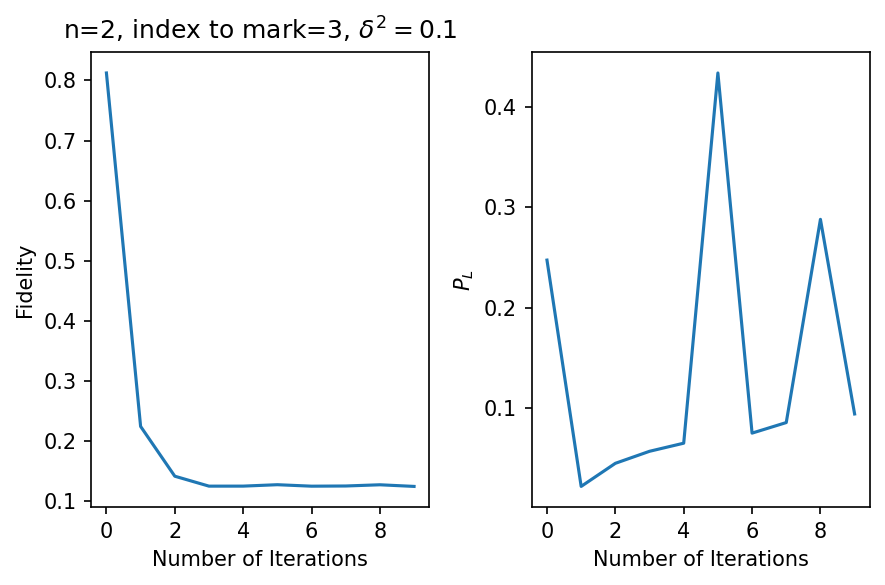

In [6]:
plt.subplot(1, 2, 1)
plt.plot(itrs, fids)
plt.ylabel("Fidelity")
plt.xlabel("Number of Iterations")
plt.tight_layout()
plt.title("n={:d}, index to mark={:d}, $\delta^2={:.5g}$".format(n, indices_to_mark, float(d)**2))

plt.subplot(1, 2, 2)
plt.plot(itrs, succ_probs)
plt.ylabel("$P_L$")
plt.xlabel("Number of Iterations")
plt.tight_layout()

plt.show()

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'x', 'cx', 'rz', 'sx']
  All-qubits errors: ['id', 'rz', 'sx', 'x', 'cx']


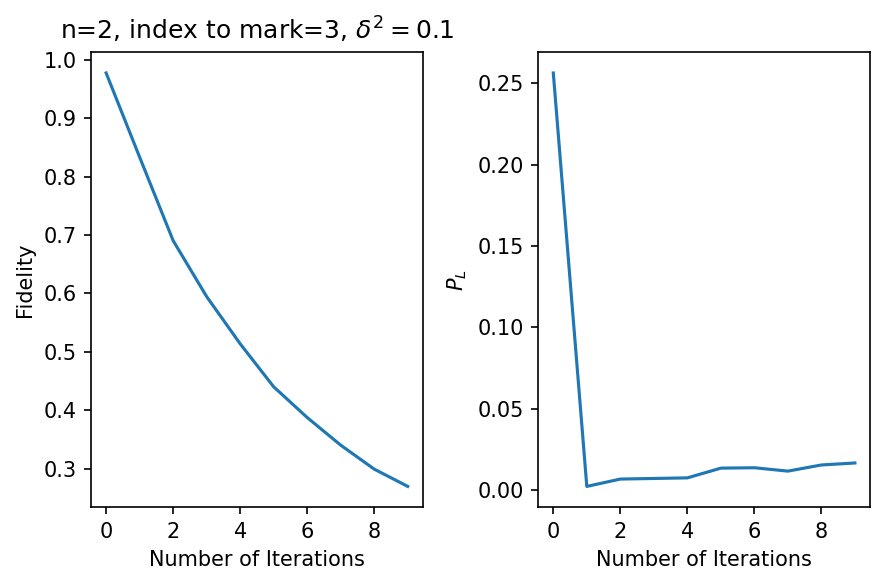

In [7]:
# Parameters
p_1q = 0.001 # 1-qubit depolarizing error rate
p_2q = 0.005 # 2-qubit depolarizing error rate

# Create an empty noise model
noise_model = NoiseModel(basis_gates) # Use the same basis_gates as the selected backend to ensure the circuit depth is the same

# Add depolarizing errors
error_1q = depolarizing_error(p_1q, 1)
error_2q = depolarizing_error(p_2q, 2)
noise_model.add_all_qubit_quantum_error(error_1q, ['id', 'rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

# Add the noise model to a simulator
sim_noise = AerSimulator(noise_model=noise_model)
print(noise_model)


itrs = range(10)
succ_probs = []
fids = []
for itr in itrs :
    g_qc = FP_Grover_circuit(n, indices_to_mark, itr, d)
    r = QuantumRegister(n+1)
    tomo_qc = QuantumCircuit(r)
    tomo_qc.compose(g_qc,inplace=True) 

    tomo_circs = state_tomography_circuits(tomo_qc, r)
    job_tomo = sim_noise.run(transpile(tomo_circs,sim_noise, optimization_level=0), shots=8192, optimization_level=0)

    fitted = StateTomographyFitter(job_tomo.result(), tomo_circs)

    job_true = execute(tomo_qc, Aer.get_backend('statevector_simulator'))
    true_state = job_true.result().get_statevector(tomo_qc)
    
    fids.append(state_fidelity(fitted.fit(), true_state))
    
    g_qc.measure_all()
    counts = sim_noise.run(g_qc, shots=8192).result().get_counts()
    no_acillary_counts = {key[0:n]:item for key, item in counts.items()}
    succ_prob = no_acillary_counts[format(indices_to_mark, '0{:d}b'.format(n))]/8192
    succ_probs.append(succ_prob)
    
    
plt.subplot(1, 2, 1)
plt.plot(itrs, fids)
plt.ylabel("Fidelity")
plt.xlabel("Number of Iterations")
plt.tight_layout()
plt.title("n={:d}, index to mark={:d}, $\delta^2={:.5g}$".format(n, indices_to_mark, float(d)**2))

plt.subplot(1, 2, 2)
plt.plot(itrs, succ_probs)
plt.ylabel("$P_L$")
plt.xlabel("Number of Iterations")
plt.tight_layout()

plt.show()